# Imports and Helpful Function Definitions

In [253]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [254]:
# Function to get historical data at daily frequency

def get_close_daily(tickers):
    # Define the date range (last 4 years)
    # end_date = datetime.today() - timedelta(days=90)
    # start_date = end_date - timedelta(days=4 * 365)

    start_date = "2020-01-01"
    end_date = "2024-01-01"

    # Download the historical data
    data = yf.download(tickers, start=start_date, end=end_date, interval="1d")["Close"]

    return data

In [255]:
# Function to Calculate the Beta of an equity using linear regression

import statsmodels.api as sm

def calc_beta(stock_ticker, market_ticker="^GSPC", start="2020-01-01", end="2024-01-01"):
    data = get_close_daily([stock_ticker, market_ticker])
    returns = data.pct_change().dropna()
    X = returns[market_ticker]
    Y = returns[stock_ticker]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    beta = model.params[market_ticker]

    return beta

In [256]:
def top_n_pairs(corr_matrix, n=10):
    corr_pairs = corr_matrix.unstack()
    corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    sorted_pairs = corr_pairs.abs().sort_values(ascending=False)
    top_n = sorted_pairs.drop_duplicates().head(n)

    return top_n

In [257]:
from statsmodels.tsa.stattools import adfuller

def test_coint(data1, data2):
  res = {}

  adf1 = adfuller(data1)
  res["adf1_p"] = adf1[1]

  adf2 = adfuller(data2)
  res["adf2_p"] = adf1[1]

  adfSpread = adfuller(data1 - data2)
  res["adf_spread"] = adfSpread[1]

  adfRat = adfuller(data1 / data2)
  res["adf_ratio"] = adfRat[1]

  return res

In [296]:
def gen_signal_perc(row):
    if row["ratio"] > row["pred_ratio"] * 1.02:
        return 0
    elif row["ratio"] < row["pred_ratio"] * 0.98:
        return 1
    else:
        return -1

# Selecting Assets

In [259]:
tickers = [
    # Technology
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "UBER", "BABA", "DOCU", "ZM", "ROKU", "META", "SHOP",
    # Financials
    "JPM", "BAC", "GS", "WFC", "AXP",
    # Healthcare
    "JNJ", "PFE", "UNH", "MRNA", "LLY",
    # Consumer Goods & Retail
    "TSLA", "WMT", "KO", "PG", "MCD",
    # Industrials
    "BA", "CAT", "GE", "UPS", "DE", "BRK-B"
]

In [260]:
# Fetch historical data from yahoo finance
dataset = get_close_daily(tickers)

[*********************100%***********************]  33 of 33 completed


In [261]:
# Calcualte the beta for each equity
betas = []
for tick in tickers:
  betas.append((tick, calc_beta(tick)))

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

In [262]:
# Take the 25 tickers with the highest betas
betas.sort(key=lambda x: x[0])
good_beta_tickers = [b[0] for b in betas[:25]]

In [263]:
# Creating a correlation matrix between these 25 equities
good_dataset = dataset[good_beta_tickers]
corr_matrix = good_dataset.corr()

In [264]:
# Find the 10 most correlated pairs
top_10_pairs = top_n_pairs(corr_matrix)
top_10_pairs

Ticker  Ticker
MSFT    AAPL      0.939222
CAT     DE        0.916954
AXP     GS        0.915066
NVDA    MSFT      0.914212
DOCU    ROKU      0.910897
BRK-B   CAT       0.909082
        MCD       0.908949
        AAPL      0.908948
AAPL    PG        0.907819
DE      BRK-B     0.904923
dtype: float64

In [265]:
# Select two assets to analyze
assetA = "BRK-B"
assetB = "MSFT"

In [266]:
# Test cointegration using ADFuller, looking for a z score < 0.05
test_coint(good_dataset[assetA], good_dataset[assetB])

{'adf1_p': 0.818176871279787,
 'adf2_p': 0.818176871279787,
 'adf_spread': 0.08299348364671871,
 'adf_ratio': 0.012971627303275158}

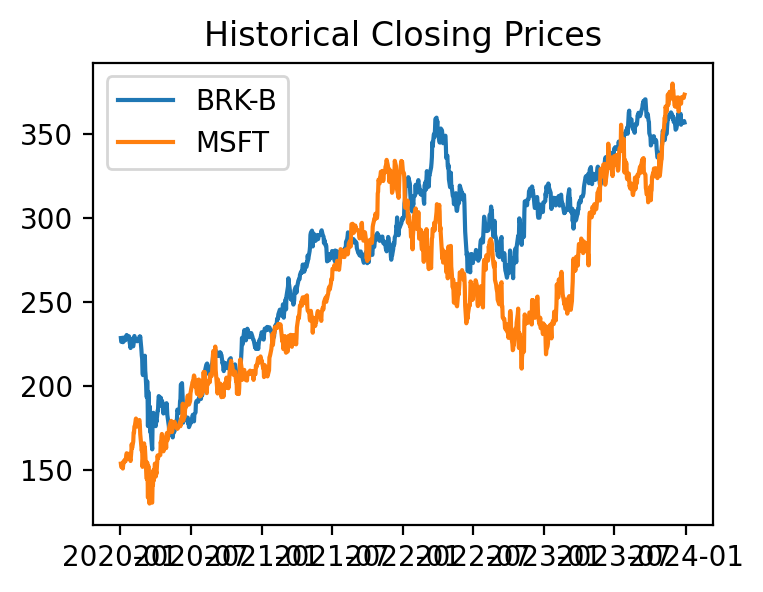

In [267]:
# Plot prices of each asset
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(good_dataset[assetA], label = assetA)
plt.plot(good_dataset[assetB], label = assetB)
plt.title('Historical Closing Prices')
plt.legend()

Text(0.5, 1.0, 'Spread')

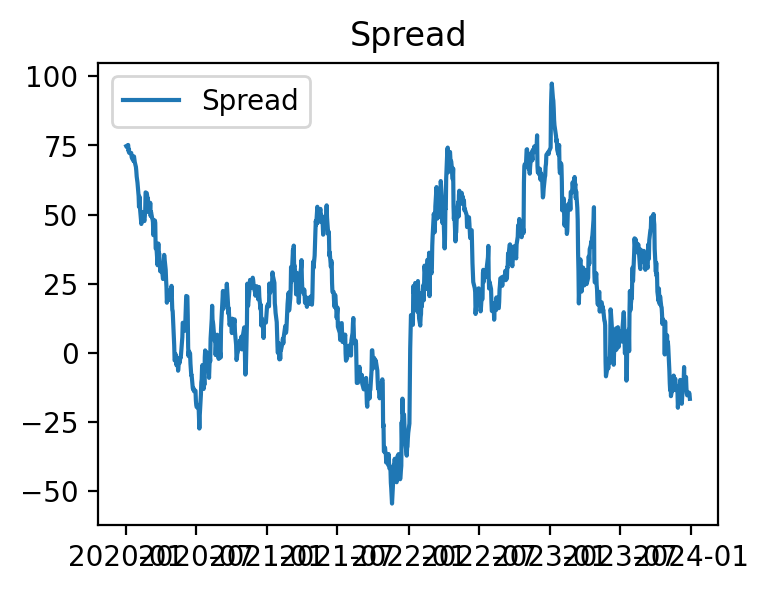

In [268]:
# Plot spread of assets
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(good_dataset[assetA] - good_dataset[assetB], label = 'Spread')
plt.legend()
plt.title("Spread")

Text(0.5, 1.0, 'Ratio between BRK-B and AAPL')

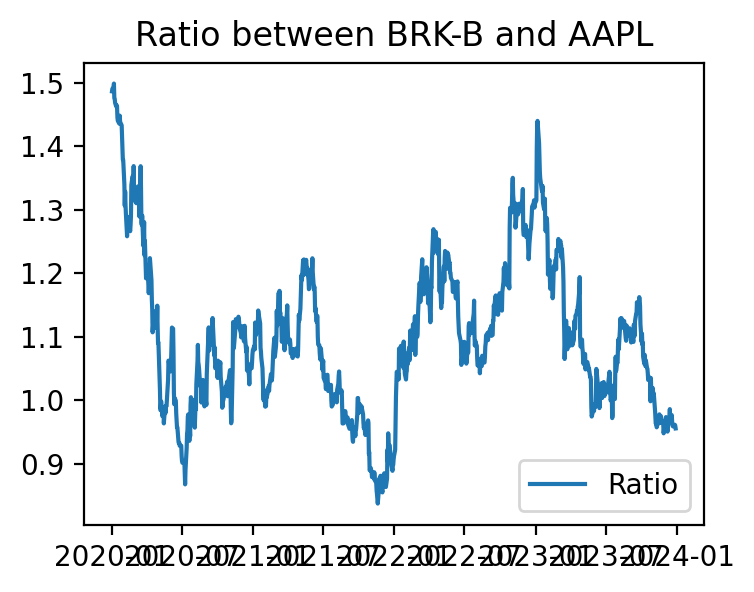

In [269]:
# Plot ratio of assets
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(good_dataset[assetA] / good_dataset[assetB], label = 'Ratio')
plt.legend()
plt.title("Ratio between BRK-B and AAPL")

In [270]:
short_window = 10
long_window = 20

In [271]:
ratio = good_dataset[assetA] / good_dataset[assetB]

In [272]:
short_ema = ratio.ewm(span=short_window, adjust=False).mean()
long_ema = ratio.ewm(span=long_window, adjust=False).mean()

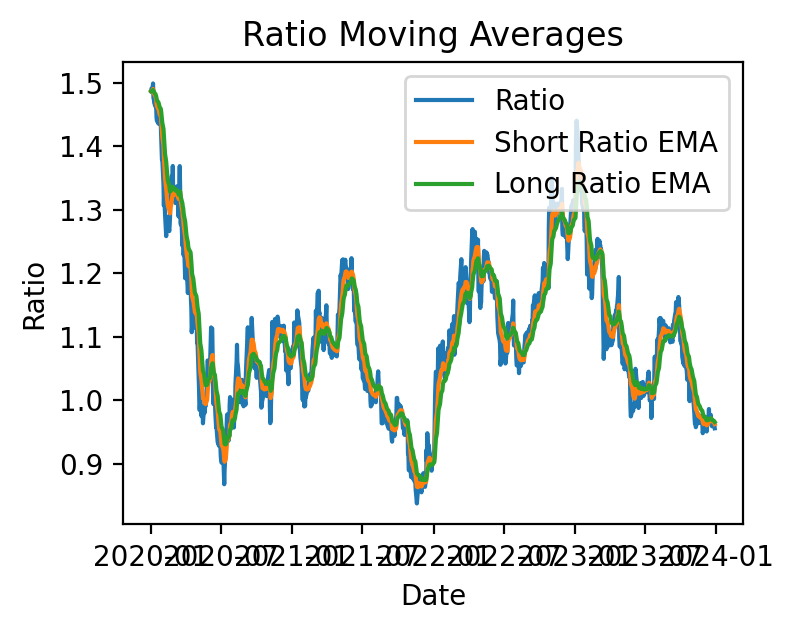

In [273]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(ratio.index, ratio.values)
plt.plot(short_ema.index, short_ema.values)
plt.plot(long_ema.index, long_ema.values)
plt.legend(['Ratio', 'Short Ratio EMA', 'Long Ratio EMA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio Moving Averages')
plt.show()

# Regression of Ratio between Asset A and Asset B

In [274]:
# We want a dataset with lags for prediction
# The actual prices of each asset
# Column for predicted ratio
# Column for moving average based signal
# Column for prediction based signal
# Difference between the training data for regression and the dataset we need for evaluation

In [275]:
# Create Lagged Dataset for regression
# Use moving averages as a lags

train_df = pd.DataFrame({"ratio": ratio})
train_df["ratio_lag1"] = df["ratio"].shift(1)
train_df["ratio_lag2"] = df["ratio"].shift(2)
train_df["short_window_lag"] = df["ratio"].ewm(span=short_window, adjust=False).mean().shift(1)
train_df["long_window_lag"] = df["ratio"].ewm(span=long_window, adjust=False).mean().shift(1)

train_df.dropna(inplace=True)

X = df[["ratio_lag1", "ratio_lag2", "short_window_lag", "long_window_lag"]]
y = df["ratio"]

In [280]:
# Predict on the last year of data in the dataset

preds = []
for i in range(len(df) - 365, len(df)):
  X_train = X.iloc[:i]
  y_train = y.iloc[:i]

  model = RandomForestRegressor(max_depth=2, random_state=42)
  model.fit(X_train, y_train)

  features = X.iloc[i].values.reshape(1, -1)
  predicted_price = model.predict(features)[0]

  preds.append(predicted_price)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

In [287]:
output_df = df[["ratio"]].iloc[-365:].copy()
output_df["pred_ratio"] = preds

In [291]:
# Calculate Z-scores

ratio_mean = output_df["ratio"].rolling(window=10).mean()
ratio_std = output_df["ratio"].rolling(window=10).std()

z_score = (output_df["ratio"] - ratio_mean) / ratio_std

output_df["z_score"] = z_score
output_df["ma_signal"] = np.where(z_score > 2, 0,
                      np.where(z_score < -2, 1, -1))

In [298]:
output_df["pred_signal"] = output_df.apply(gen_signal_perc, axis=1)

# Evaluate Strategy

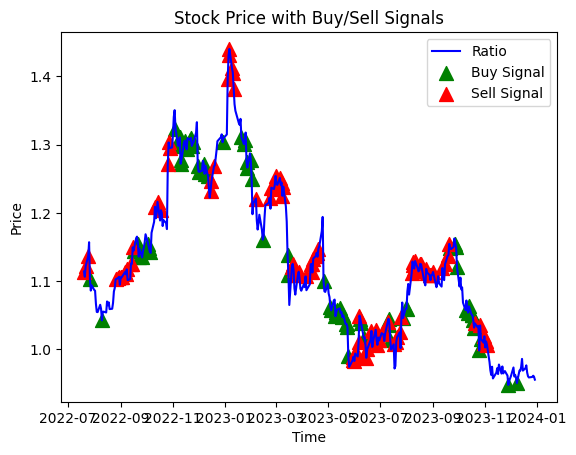

In [299]:
plt.plot(output_df["ratio"], linestyle='-', color='blue', label="Ratio")

plt.scatter(output_df.index[output_df["pred_signal"] == 1], output_df["ratio"][output_df["pred_signal"] == 1],
            color='green', marker='^', s=100, label="Buy Signal")

plt.scatter(output_df.index[output_df["pred_signal"] == 0], output_df["ratio"][output_df["pred_signal"] == 0],
            color='red', marker='^', s=100, label="Sell Signal")

# Show legend and plot
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Stock Price with Buy/Sell Signals")
plt.show()

In [300]:
output_df["priceA"] = good_dataset[assetA]
output_df["priceB"] = good_dataset[assetB]

output_df["returnA"] = np.log(df["priceA"] / df["priceA"].shift(1))
output_df["returnB"] = np.log(df["priceB"] / df["priceB"].shift(1))

In [301]:
output_df["strategy_return"] = output_df["pred_signal"].shift(1) * (output_df["returnB"] - output_df["returnA"])
output_df.fillna(0, inplace=True)
output_df["cumulative_return"] = (1 + output_df["strategy_return"]).cumprod()

In [302]:
sharpe_ratio = output_df["strategy_return"].mean() / output_df["strategy_return"].std() * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Sharpe Ratio: 1.60
